## Importing Libraries

In [44]:
%time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

import joblib

from wordcloud import WordCloud
from collections import Counter

CPU times: total: 0 ns
Wall time: 0 ns


# Data Proprocessing

## Loading Data

Load the data, and have an overview of the data

In [45]:
data = pd.read_csv('Suicide_Detection.csv')

print(data.head(),"\n")
print(data.info(),"\n")
print("Shape: ",data.shape)

# Convert string to 0/1 values
data['is_suicide'] = data['class'].apply(lambda x: 1 if x == 'suicide' else 0)

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB
None 

Shape:  (232074, 3)


The column 'Unnammed: 0' is a meaningless column at here, thus we can delete it

In [46]:
data.drop(columns = 'Unnamed: 0', inplace=True)
data.head()

,text,class,is_suicide
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1
1,Am I weird I don't get affected by compliments...,non-suicide,0
2,Finally 2020 is almost over... So I can never ...,non-suicide,0
3,i need helpjust help me im crying so hard,suicide,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1


Check is null value available

In [47]:
data.isnull().sum()

text          0
class         0
is_suicide    0
dtype: int64

### Features Engineering

In [48]:
data['total_words'] = data['text'].apply(lambda x: len(x.split()))
data.head()

,text,class,is_suicide,total_words
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1,143
1,Am I weird I don't get affected by compliments...,non-suicide,0,27
2,Finally 2020 is almost over... So I can never ...,non-suicide,0,26
3,i need helpjust help me im crying so hard,suicide,1,9
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1,438


## Data Visualization

Proportion of suicide and non-suicide thoughts

1    116037
0    116037
Name: is_suicide, dtype: int64


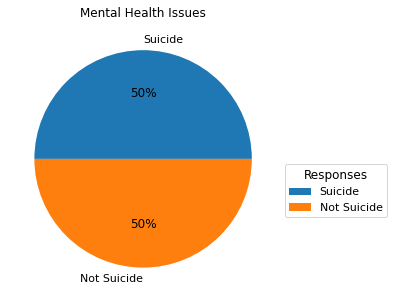

In [49]:
classCount = data["is_suicide"].value_counts()
print(classCount)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)
plt.title('Mental Health Issues')
plt.pie(classCount, labels=['Suicide', 'Not Suicide'], autopct='%.0f%%')

# Add a legend outside the pie chart
plt.legend(title="Responses", loc="upper left", bbox_to_anchor=(1, 0.5))

# Add a legend outside the pie chart

plt.show()

## Text Processing

Lower Case, Remove Puncutuations, Remove Stop Words

In [50]:
# Convert texts to lower case
data['preprocessed_text'] = data['text'].str.lower()

# Remove punctuations
data['preprocessed_text'] = data['preprocessed_text'].str.replace(r'[^\w\s]+','',regex=True)

# Remove stop words
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Tokenize the words
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x:nltk.word_tokenize(x))

### Lemmatization

In [51]:
%time
# Lemmatize the words
lemmatizer = WordNetLemmatizer()
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: [lemmatizer.lemmatize(word,pos='v') for word in x])

# ps = PorterStemmer()
# data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: [ps.stem(i) for i in x])

# Combine the words
data['preprocessed_text'] = data['preprocessed_text'].apply(lambda x: ' '.join(x))

data.head()

CPU times: total: 0 ns
Wall time: 0 ns


,text,class,is_suicide,total_words,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1,143,ex wife threaten suiciderecently leave wife go...
1,Am I weird I don't get affected by compliments...,non-suicide,0,27,weird dont get affect compliment come someone ...
2,Finally 2020 is almost over... So I can never ...,non-suicide,0,26,finally 2020 almost never hear 2020 bad year e...
3,i need helpjust help me im crying so hard,suicide,1,9,need helpjust help im cry hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1,438,im losthello name adam 16 ive struggle years i...


### Words Frequency

show words commonly used when expressing suicidal thought

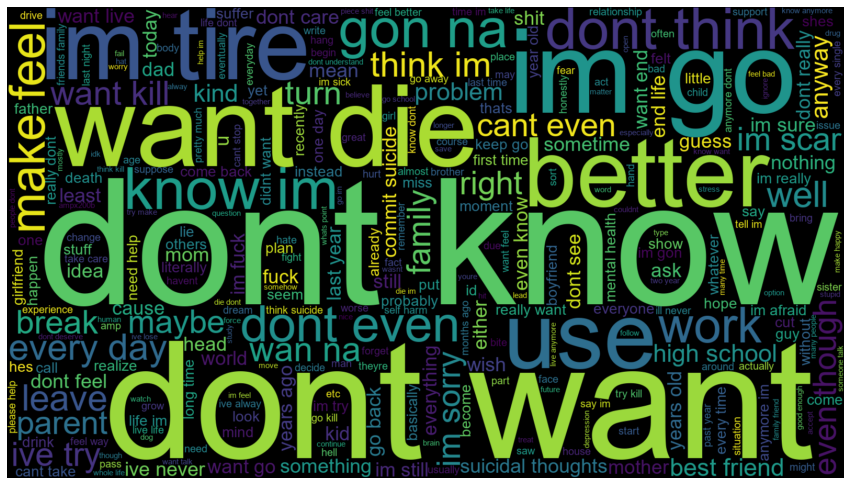

In [52]:
# Generate word cloud of suicidal thoughts

suicidal_thoughts = " ".join(data[data['is_suicide'] == 1]['preprocessed_text'])

plt.figure(figsize=(15,10))
wordcloud = WordCloud(max_words = 300, height = 900, width = 1600, background_color='black',colormap='viridis',font_path='arial.ttf').generate(suicidal_thoughts)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

show words ranking of suicidal thought

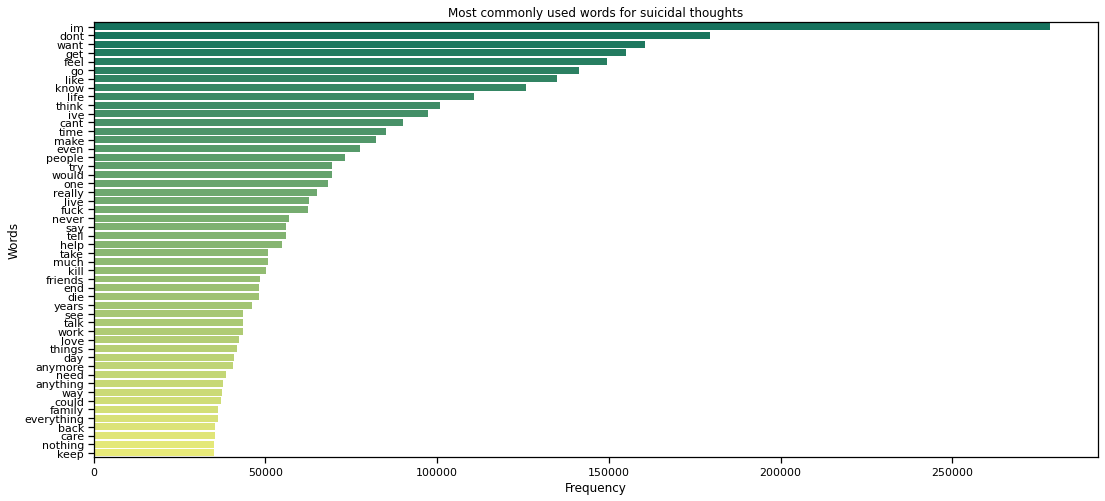

In [53]:
depression_words_ranking = []
for sentence in data[data['is_suicide'] == 1]['preprocessed_text'].to_list():
    for word in sentence.split():
        depression_words_ranking.append(word)
        
df = pd.DataFrame(Counter(depression_words_ranking).most_common(50),columns=['Word','Frequency'])

sns.set_context('notebook')
plt.figure(figsize=(18,8))
sns.barplot(y=df['Word'], x=df['Frequency'],palette='summer')
plt.title('Most commonly used words for suicidal thoughts')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

## Split Data

In [54]:
x,y = data['preprocessed_text'],data['is_suicide']

vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x = vectorizer.fit_transform(x).toarray()

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=3)
X_train.shape, X_test.shape

((185659, 5000), (46415, 5000))

# Models Predictions

## Naive Bayes

In [57]:
%time

naive_bayes_gaussian = GaussianNB()
naive_bayes_bernoulli = BernoulliNB()
naive_bayes_multinomial = MultinomialNB()

VotingClassifiers = VotingClassifier(
    estimators=[
        ('GaussianNB',naive_bayes_gaussian),
        ('Bernoulli',naive_bayes_bernoulli),
        ('Multinomial',naive_bayes_multinomial)
    ],voting='soft'
)

VotingClassifiers.fit(X_train,y_train)

nb_prediction = VotingClassifiers.predict(X_test)
nb_confussion_matrix = confusion_matrix(y_test,nb_prediction)
nb_accuracy = accuracy_score(y_test,nb_prediction)

# Score for Training
print("Training Score = ",VotingClassifiers.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",VotingClassifiers.score(X_test,y_test))

print("Confussion Matrix : ", nb_confussion_matrix)
print(classification_report(y_test,nb_prediction))

CPU times: total: 0 ns
Wall time: 0 ns


MemoryError: Unable to allocate 6.92 GiB for an array with shape (185659, 5000) and data type float64

## Random Forest

In [ ]:
%time

# random_forest_classifier = RandomizedSearchCV(
#     RandomForestClassifier(),
#     {
#         'n_estimators':[4,5],
#         'criterion':['entropy'],
#         'max_depth':range(1,4),'min_samples_split':range(2,5)
#     }, random_state=10
# )

random_forest_classifier = RandomForestClassifier(n_estimators=100)

random_forest_classifier.fit(X_train,y_train)

# Score for Training
print("Training Score = ",random_forest_classifier.score(X_train,y_train))

# Score for Testing
print("Testing Score = ",random_forest_classifier.score(X_test,y_test))

## Decision Tree

In [ ]:
%time

decision_tree_classifier = DecisionTreeClassifier(criterion='gini',splitter='random',min_samples_leaf=100,max_depth=6,random_state=0)
decision_tree_classifier.fit(X_train,y_train)
                             
# Score for Training
print("Training Score = ",decision_tree_classifier.score(X_train,y_train))
                             
# Score for Testing
print("Testing Score = ",decision_tree_classifier.score(X_test,y_test))

# Conclusion

In [ ]:
model_ev = pd.DataFrame({
    'Model':['Naive Bayes','Random Forest','Decision Tree'],
    'Accuracy':[nb_accuracy,nb_accuracy,nb_accuracy]
})

model_ev

Naive Bayes is the best fit model for the given dataset as it has the values,
- Training Score: 0.9024567408018418
- Testing Score =  0.8993723338551916

### Save Model

In [ ]:
joblib.dump(VotingClassifiers,'naive_bayes_model.joblib')

In [ ]:
def preprocess(word):
    word = word.lower()
    word = word.replace(r'[^\w\s]+','')
    word = [word for word in word.split() if word not in (stop_words)]
    word = ' '.join([ps.stem(i) for i in word])
    return vectorizer.transform([word]).toarray()

def mental_health_issue_detector(text):
    print("Input = ",text)
    processed_word = preprocess(text)
    prediction = VotingClassifiers.predict(processed_word)
    print(prediction[0])

## User Input

In [ ]:
mental_health_issue_detector("love")